In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from xgboost import XGBClassifier 
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
import math

from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, balanced_accuracy_score
RANDOM_STATE = 42

# load data

In [3]:
X = np.load("Descriptor1/Descriptor1_complete_features.npy")  
# X = np.load("Descriptor1_complete_features_fixed.npy")  
# X = np.load("Descriptor1_complete_features_new.npy")  
# X = np.load("Descriptor1_complete_features_stats.npy")   # w mean std of eigenvals
y = np.load("Descriptor1/Descriptor1_complete_targets.npy")   

# X = X[:, :-1]
print(X.shape)

(1452, 147)



=== charge ===
Class 0 - mean = -0.015, std = 0.344
Class 1 - mean = 0.031, std = 0.342


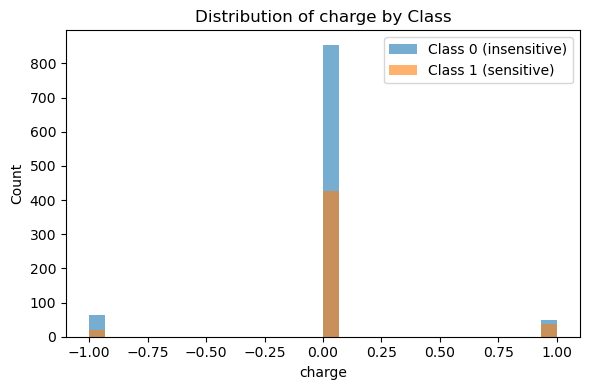


=== spin ===
Class 0 - mean = 1.090, std = 0.368
Class 1 - mean = 1.292, std = 0.506


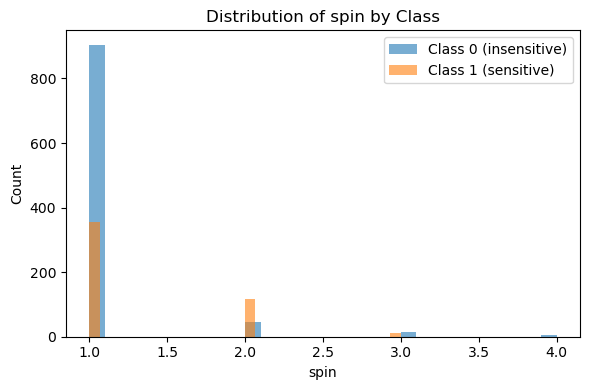


=== #eigenval ===
Class 0 - mean = 19.613, std = 16.238
Class 1 - mean = 13.342, std = 16.089


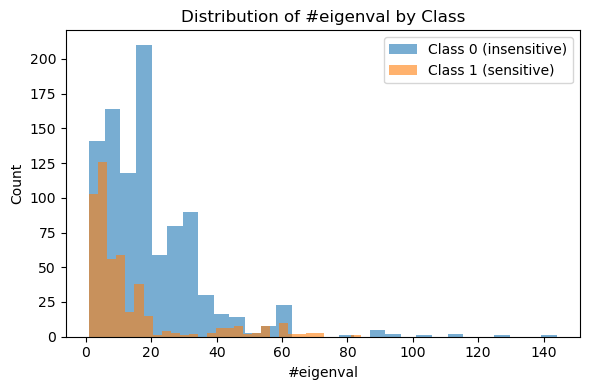

In [4]:
# Separate classes
X0 = X[y == 0]   # class 0 samples
X1 = X[y == 1]   # class 1 samples

cols = [-3, -2, -1]
col_names = ["charge", "spin", "#eigenval"]

for c, name in zip(cols, col_names):
    v0 = X0[:, c]
    v1 = X1[:, c]

    print(f"\n=== {name} ===")
    print(f"Class 0 - mean = {v0.mean():.3f}, std = {v0.std():.3f}")
    print(f"Class 1 - mean = {v1.mean():.3f}, std = {v1.std():.3f}")

    plt.figure(figsize=(6,4))
    plt.hist(v0, bins=30, alpha=0.6, label="Class 0 (insensitive)")
    plt.hist(v1, bins=30, alpha=0.6, label="Class 1 (sensitive)")
    plt.xlabel(name)
    plt.ylabel("Count")
    plt.legend()
    plt.title(f"Distribution of {name} by Class")
    plt.tight_layout()
    plt.show()


# class imbalance ratio

In [5]:
unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Class {label}: {count} samples ({count/len(y):.2%})")

Class 0: 969 samples (66.74%)
Class 1: 483 samples (33.26%)


# identifying columns with >= 99 % zeros

In [6]:
# first 144 
X_eig = X[:, :144]

# how often each column is zero 
zero_rate = (X_eig == 0).mean(axis=0)
nonzero_count = (X_eig != 0).sum(axis=0)

# sorted summary (most-zero first)
order = np.argsort(-zero_rate)
summary = pd.DataFrame({
    "eig_col": order,                 # 0-based index within the 144 eig cols
    "zero_rate": zero_rate[order],
    "nonzero_count": nonzero_count[order]
})
print(summary.head(100).to_string(index=False))

# columns that are ≥99% zero
cols_99 = np.where(zero_rate >= 0.99)[0]
print("\nCols ≥99% zero (0-based):", cols_99.tolist())        #index start from 0 
#print("Cols ≥99% zero (1-based):", (cols_99 + 1).tolist())   #index start from 1 

 eig_col  zero_rate  nonzero_count
     143   0.999311              1
     128   0.999311              1
     129   0.999311              1
     130   0.999311              1
     131   0.999311              1
     132   0.999311              1
     133   0.999311              1
     134   0.999311              1
     142   0.999311              1
     136   0.999311              1
     137   0.999311              1
     138   0.999311              1
     139   0.999311              1
     140   0.999311              1
     141   0.999311              1
     135   0.999311              1
     112   0.998623              2
     113   0.998623              2
     114   0.998623              2
     115   0.998623              2
     116   0.998623              2
     117   0.998623              2
     118   0.998623              2
     121   0.998623              2
     120   0.998623              2
     122   0.998623              2
     123   0.998623              2
     124   0.998623 

# distribution of feature sized (before padding) 

n=1452 | mean=17.527 | median=13.000 | std=16.461


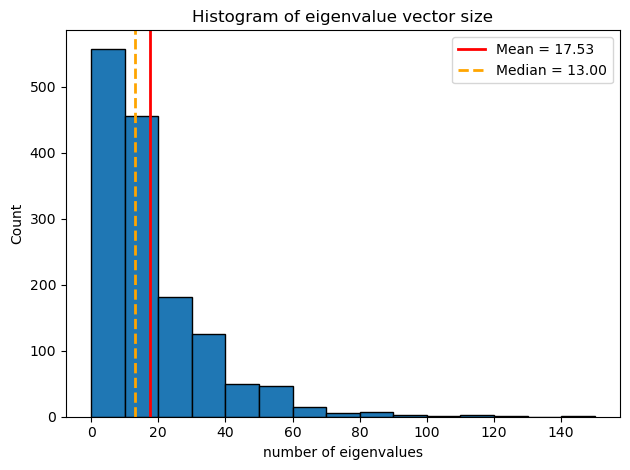

In [7]:
vals = X[:, -1]

# Compute stats
vals_mean = float(np.mean(vals))
vals_median = float(np.median(vals))
vals_std = float(np.std(vals, ddof=1)) if vals.size > 1 else float("nan")

print(f"n={vals.size} | mean={vals_mean:.3f} | median={vals_median:.3f} | std={vals_std:.3f}")

bin_width = 10
min_edge = math.floor(vals.min() / bin_width) * bin_width
max_edge = math.ceil(vals.max() / bin_width) * bin_width
bins = np.arange(min_edge, max_edge + bin_width, bin_width)

# Histogram
plt.figure()
plt.hist(vals, bins=bins, edgecolor="black")
plt.axvline(vals_mean, color="red", linestyle='-', linewidth=2, label=f"Mean = {vals_mean:.2f}")
plt.axvline(vals_median, color="orange", linestyle='--', linewidth=2, label=f"Median = {vals_median:.2f}")
plt.xlabel("number of eigenvalues")
plt.ylabel("Count")
plt.title("Histogram of eigenvalue vector size")
plt.legend()
plt.tight_layout()
plt.show()



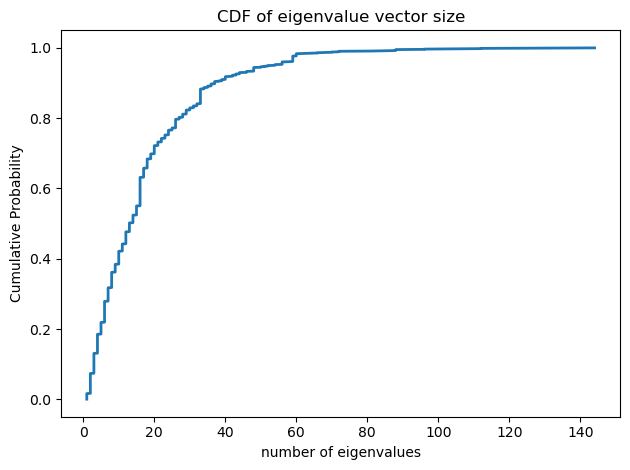

In [8]:
# CDF
plt.figure()
sorted_vals = np.sort(vals)
cdf = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
plt.plot(sorted_vals, cdf, linewidth=2)
plt.xlabel("number of eigenvalues")
plt.ylabel("Cumulative Probability")
plt.title("CDF of eigenvalue vector size")
plt.tight_layout()
plt.show()

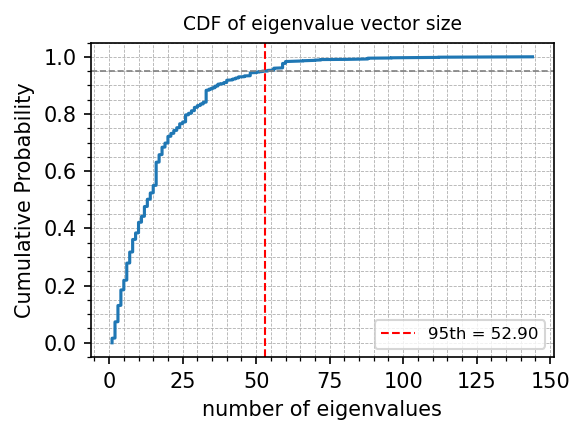

In [9]:
#  CDF with 0.95 marker
plt.figure(figsize=(4, 3), dpi=150)
sorted_vals = np.sort(vals)
cdf = np.linspace(0, 1, len(sorted_vals), endpoint=True)

plt.plot(sorted_vals, cdf, linewidth=1.5)

# 95th percentile
p95 = np.percentile(vals, 95)
plt.axvline(p95, color='r', linestyle='--', linewidth=1, label=f"95th = {p95:.2f}")
plt.axhline(0.95, color='gray', linestyle='--', linewidth=0.8)

plt.xlabel("number of eigenvalues")
plt.ylabel("Cumulative Probability")
plt.title("CDF of eigenvalue vector size", fontsize=9)
plt.legend(fontsize=8, loc="lower right")

plt.grid(True, which='both', linestyle='--', linewidth=0.4)
plt.minorticks_on()

plt.tight_layout()
plt.show()


# keeping top 52 + meta data (charge/spin/size)

In [10]:
# Eigenvalues + meta data 
K = 53 
X = np.hstack([X[:, :K], X[:, -3:]])

print( "Trimmed shape:", X.shape)

Trimmed shape: (1452, 56)


# train test split

In [11]:
# 20/80 split. 
# 20 % for our hold out test set 
# 80 % for hyperparam tuning, ...
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,        # preserve 66/34 balance
    random_state=RANDOM_STATE
)

print("Train/Val size:", X_trainval.shape[0])
print("Test size:", X_test.shape[0])

Train/Val size: 1161
Test size: 291


# XGB selecting k & params

In [44]:
RANDOM_STATE = 42
from sklearn.metrics import make_scorer, recall_score

neg = (y_trainval == 0).sum()
pos = (y_trainval == 1).sum()
spw = neg / max(pos, 1)

K_list = [5,6,7,8,9,10,11,12,13,14,15,16, 17, 18,19,20,22, 24,25, 30, 32,40,48,50,60,72]
# K_list = list(range(1, 73))
# K_list = [10,20,30,40,50,60,70]
K_list = [ 17, 18,19,20,22, 24,25, 30, 32,40,48,50,60,72]
K_list = list(range(13, 54))
# K_list = list(range(0, 54))
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# search space 
param_dist = {
    "n_estimators": [ 200, 300, 400, 500 ], #, 600, 800, 1000],
    "max_depth": [3, 4, 5, 6, 8, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 1, 5],
    "min_child_weight": [1, 3, 5],
}

# scoring metrics
scoring = {"bal_acc": "balanced_accuracy", "acc": "accuracy"}

results = []          # list of dicts per K
search_by_K = {}      # keep the fitted search object to reuse the winner's best_estimator_

for K in K_list:
    # print(K)
    Xi = np.hstack([X_trainval[:, :K], X_trainval[:, -3:]]) #top k eigneval + 3 metadata
    xgb = XGBClassifier(random_state=RANDOM_STATE, 
                        eval_metric="logloss", 
                       scale_pos_weight=spw
                       )
    search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_dist,
        n_iter=50,
        scoring=scoring,
        refit="bal_acc",
        cv=inner_cv,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=0, 
    )
    
    search.fit(Xi, y_trainval)

    best_idx = search.best_index_
    splits = inner_cv.get_n_splits()

    # per-fold scores for std (balanced acc and accuracy)
    bal_folds = [search.cv_results_[f"split{i}_test_bal_acc"][best_idx] for i in range(splits)]
    acc_folds = [search.cv_results_[f"split{i}_test_acc"][best_idx]     for i in range(splits)]

    rec = {"K": K,
            "bal_mean": float(search.cv_results_["mean_test_bal_acc"][best_idx]),
            "bal_std":  float(np.std(bal_folds)),
            "acc_mean": float(search.cv_results_["mean_test_acc"][best_idx]),
            "acc_std":  float(np.std(acc_folds)),
            "best_params": search.best_params_,
    }
    results.append(rec)
    search_by_K[K] = search

python(17965) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17966) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17967) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17968) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17969) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17970) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17971) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17972) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


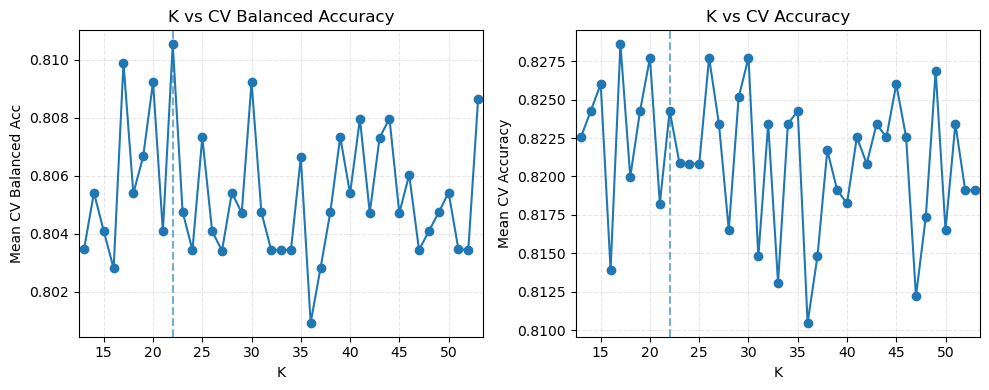

In [45]:
df = pd.DataFrame(results).sort_values("K").reset_index(drop=True)

# Best K by balanced accuracy (tie-break: acc_mean, then smaller K)
best_rec = max(df.to_dict("records"), key=lambda d: (d["bal_mean"], d["acc_mean"], -d["K"]))
K_star = best_rec["K"]

# Plots: left = K vs CV Balanced Acc, right = K vs CV Accuracy (no std/error bars)
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

# Left: balanced accuracy
axes[0].plot(df["K"], df["bal_mean"], "o-")
axes[0].axvline(K_star, linestyle="--", alpha=0.6)
axes[0].set_title("K vs CV Balanced Accuracy")
axes[0].set_xlabel("K")
axes[0].set_ylabel("Mean CV Balanced Acc")
axes[0].grid(alpha=0.3, linestyle="--")

# Right: accuracy
axes[1].plot(df["K"], df["acc_mean"], "o-")
axes[1].axvline(K_star, linestyle="--", alpha=0.6)
axes[1].set_title("K vs CV Accuracy")
axes[1].set_xlabel("K")
axes[1].set_ylabel("Mean CV Accuracy")
axes[1].grid(alpha=0.3, linestyle="--")

#  x-limits to tested Ks
axes[1].set_xlim(df["K"].min() - 0.5, df["K"].max() + 0.5)

plt.tight_layout()
plt.show()

In [46]:
#  summary sorted by balanced accuracy
results.sort(key=lambda d: d["bal_mean"], reverse=True)

print("\n=== XGB RandomizedSearch (5-fold), per-K summary — sorted by balanced accuracy ===")
print(" K   bal_mean  bal_sd   acc_mean  acc_sd ")
for r in results:
    print(f"{r['K']:2d}   {r['bal_mean']:.3f}    {r['bal_std']:.3f}    "
          f"{r['acc_mean']:.3f}    {r['acc_std']:.3f}")

# best k 
best = max(results, key=lambda d: (d["bal_mean"], d["acc_mean"], -d["K"]))
K_star = best["K"]
winner = best

print(f"\n>>> Selected K* = {K_star} by BEST bal_acc "
      f"(best bal_acc={best['bal_mean']:.3f}±{best['bal_std']:.3f}; "
      f"acc_mean={best['acc_mean']:.3f}±{best['acc_std']:.3f})")
print("Winner params:", winner.get("best_params"))


=== XGB RandomizedSearch (5-fold), per-K summary — sorted by balanced accuracy ===
 K   bal_mean  bal_sd   acc_mean  acc_sd 
22   0.811    0.016    0.824    0.014
17   0.810    0.018    0.829    0.012
20   0.809    0.027    0.828    0.024
30   0.809    0.026    0.828    0.022
53   0.809    0.011    0.819    0.016
44   0.808    0.020    0.823    0.022
41   0.808    0.022    0.823    0.020
39   0.807    0.013    0.819    0.012
25   0.807    0.011    0.821    0.011
43   0.807    0.021    0.823    0.023
19   0.807    0.023    0.824    0.020
35   0.807    0.020    0.824    0.021
46   0.806    0.014    0.823    0.014
28   0.805    0.013    0.817    0.009
50   0.805    0.016    0.817    0.018
14   0.805    0.022    0.824    0.017
40   0.805    0.017    0.818    0.016
18   0.805    0.020    0.820    0.014
23   0.805    0.028    0.821    0.022
38   0.805    0.023    0.822    0.018
31   0.805    0.018    0.815    0.019
49   0.805    0.017    0.827    0.014
42   0.805    0.022    0.821    0.023


In [66]:
# # --- Manually set K* ---
# results.sort(key=lambda d: d["bal_mean"], reverse=True)

# print("\n=== XGB RandomizedSearch (5-fold), per-K summary — sorted by balanced accuracy ===")
# print(" K   bal_mean  bal_sd   acc_mean  acc_sd ")
# for r in results:
#     print(f"{r['K']:2d}   {r['bal_mean']:.3f}    {r['bal_std']:.3f}    "
#           f"{r['acc_mean']:.3f}    {r['acc_std']:.3f}")

# # Manually choose K*
# K_star = 9
# winner = next((r for r in results if r["K"] == K_star), None)
# if winner is None:
#     raise ValueError(f"K={K_star} not found in results.")

# print(f"\n>>> Manually selected K* = {K_star} "
#       f"(bal_acc={winner['bal_mean']:.3f}±{winner['bal_std']:.3f}; "
#       f"acc_mean={winner['acc_mean']:.3f}±{winner['acc_std']:.3f})")
# print("Winner params:", winner.get("best_params"))


In [ ]:
# # slightly lower cutoff at inference 
# from sklearn.metrics import accuracy_score, recall_score, precision_score, balanced_accuracy_score

# # 1) Pick K* the same way (by balanced accuracy, tie-break by acc, then smaller K)
# best = max(results, key=lambda d: (d["bal_mean"], d["acc_mean"], -d["K"]))
# K_star = best["K"]
# best_search = search_by_K[K_star]
# best_model = best_search.best_estimator_  # already refit on all trainval folds

# # 2) Build the matching feature views for K*
# Xi_train = np.hstack([X_trainval[:, :K_star], X_trainval[:, -3:]])
# Xi_test  = np.hstack([X_test[:, :K_star],     X_test[:, -3:]])

# #  reduce the decision cutoff 
# THRESHOLD = 0.5

# # 4) Predict with the adjusted threshold
# proba_train = best_model.predict_proba(Xi_train)[:, 1]
# y_pred_train = (proba_train >= THRESHOLD).astype(int)

# proba_test = best_model.predict_proba(Xi_test)[:, 1]
# y_pred_test = (proba_test >= THRESHOLD).astype(int)

# # 5) quick report
# print(f"K* = {K_star}, threshold = {THRESHOLD:.2f}")
# print("Train  | Acc:",
#       f"{accuracy_score(y_trainval, y_pred_train):.3f}",
#       "BalAcc:", f"{balanced_accuracy_score(y_trainval, y_pred_train):.3f}",
#       "Recall:", f"{recall_score(y_trainval, y_pred_train, zero_division=0):.3f}",
#       "Prec:",   f"{precision_score(y_trainval, y_pred_train, zero_division=0):.3f}")

# print("Test   | Acc:",
#       f"{accuracy_score(y_test, y_pred_test):.3f}",
#       "BalAcc:", f"{balanced_accuracy_score(y_test, y_pred_test):.3f}",
#       "Recall:", f"{recall_score(y_test, y_pred_test, zero_division=0):.3f}",
#       "Prec:",   f"{precision_score(y_test, y_pred_test, zero_division=0):.3f}")


In [47]:
print(K_star)

# Refit on all train/val with K* and evaluate on test 
X_trainval_k = np.hstack([X_trainval[:, :K_star], X_trainval[:, -3:]])
X_test_k     = np.hstack([X_test[:, :K_star],     X_test[:, -3:]])

best_xgb = search_by_K[K_star].best_estimator_   # already refit on all train/val by RandomizedSearchCV
best_xgb.fit(X_trainval_k, y_trainval)           #  re-fit 

# Train eval
y_pred_tr = best_xgb.predict(X_trainval_k)
y_prob_tr = best_xgb.predict_proba(X_trainval_k)[:, 1]
print("\n=== XGBoostTrain Set Performance ===")
print(classification_report(y_trainval, y_pred_tr, digits=2))
print("Train Accuracy:", accuracy_score(y_trainval, y_pred_tr))
print("Train Balanced Acc:", balanced_accuracy_score(y_trainval, y_pred_tr))
print("Train ROC-AUC:", roc_auc_score(y_trainval, y_prob_tr))
print("Train PR-AUC:", average_precision_score(y_trainval, y_prob_tr))

y_pred_te = best_xgb.predict(X_test_k)
y_prob_te = best_xgb.predict_proba(X_test_k)[:, 1]
print("\n=== XGBoost Test Set Performance ===")
print(classification_report(y_test, y_pred_te, digits=2))
print("Test Accuracy:", accuracy_score(y_test, y_pred_te))
print("Test Balanced Acc:", balanced_accuracy_score(y_test, y_pred_te))
print("Test ROC-AUC:", roc_auc_score(y_test, y_prob_te))
print("Test PR-AUC:", average_precision_score(y_test, y_prob_te))

22

=== XGBoostTrain Set Performance ===
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       775
           1       0.86      0.97      0.91       386

    accuracy                           0.94      1161
   macro avg       0.92      0.94      0.93      1161
weighted avg       0.94      0.94      0.94      1161

Train Accuracy: 0.9371231696813093
Train Balanced Acc: 0.9444509443423033
Train ROC-AUC: 0.9852849740932642
Train PR-AUC: 0.966490598245342

=== XGBoost Test Set Performance ===
              precision    recall  f1-score   support

           0       0.89      0.84      0.86       194
           1       0.71      0.78      0.75        97

    accuracy                           0.82       291
   macro avg       0.80      0.81      0.80       291
weighted avg       0.83      0.82      0.82       291

Test Accuracy: 0.8213058419243986
Test Balanced Acc: 0.8118556701030928
Test ROC-AUC: 0.8830640875757254
Test PR-AUC: 0.8127454

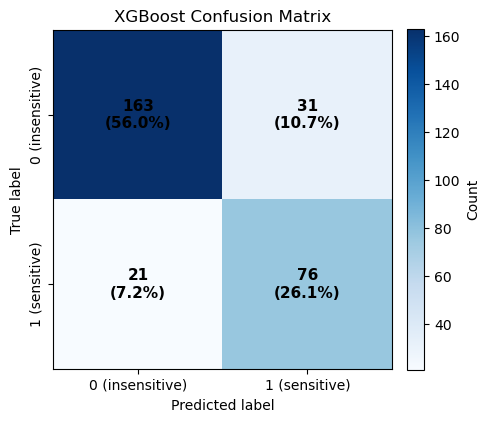

In [19]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_te, labels=[0,1])  # [[TN, FP],[FN, TP]]
TN, FP, FN, TP = cm.ravel()
N = cm.sum()

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm, cmap="Blues")

ax.set_title("XGBoost Confusion Matrix")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_xticks([0,1]); ax.set_xticklabels(["0 (insensitive)", "1 (sensitive)"])
ax.set_yticks([0,1])
ax.set_yticklabels(["0 (insensitive)", "1 (sensitive)"], rotation=90, va="center")  # ⬅️ rotated

for (i, j), v in np.ndenumerate(cm):
    pct = 100.0 * v / N
    ax.text(j, i, f"{v}\n({pct:.1f}%)", ha="center", va="center",
            fontsize=11, color="black", fontweight="bold")

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Count")
plt.tight_layout()
plt.show()



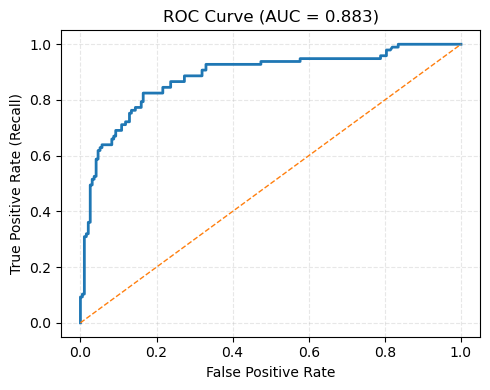

In [20]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thr = roc_curve(y_test, y_prob_te)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1], [0,1], linestyle="--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title(f"ROC Curve (AUC = {roc_auc:.3f})")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()


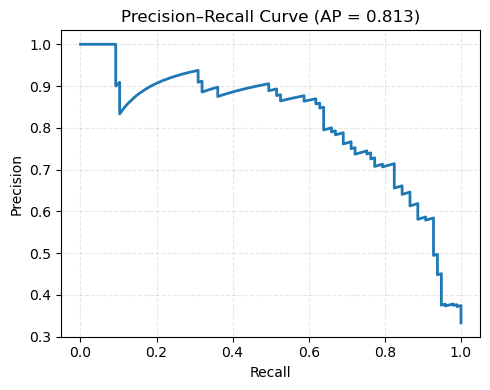

In [21]:
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, thr = precision_recall_curve(y_test, y_prob_te)
ap = average_precision_score(y_test, y_prob_te)

plt.figure(figsize=(5,4))
plt.plot(rec, prec, lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve (AP = {ap:.3f})")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()


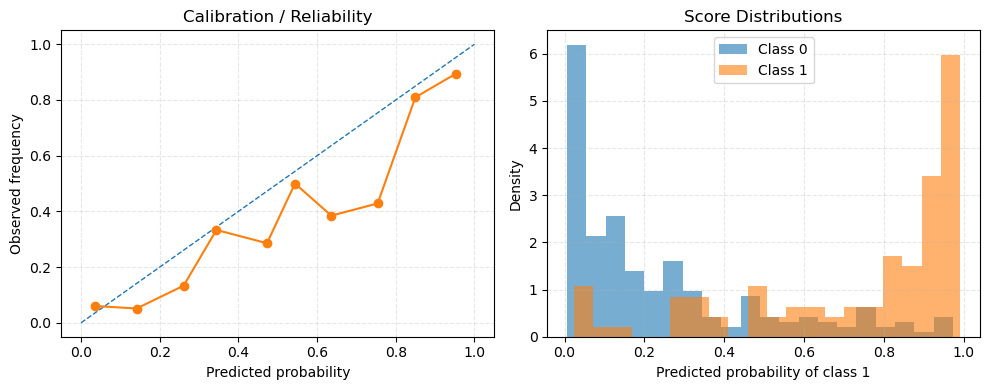

In [22]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_prob_te, n_bins=10, strategy="uniform")

fig, ax = plt.subplots(1, 2, figsize=(10,4))

# Reliability
ax[0].plot([0,1], [0,1], "--", lw=1)
ax[0].plot(prob_pred, prob_true, marker="o")
ax[0].set_title("Calibration / Reliability")
ax[0].set_xlabel("Predicted probability")
ax[0].set_ylabel("Observed frequency")
ax[0].grid(alpha=0.3, linestyle="--")

# Histogram of scores by class
ax[1].hist(y_prob_te[y_test==0], bins=20, alpha=0.6, label="Class 0", density=True)
ax[1].hist(y_prob_te[y_test==1], bins=20, alpha=0.6, label="Class 1", density=True)
ax[1].set_title("Score Distributions")
ax[1].set_xlabel("Predicted probability of class 1")
ax[1].set_ylabel("Density")
ax[1].legend()
ax[1].grid(alpha=0.3, linestyle="--")

plt.tight_layout()
plt.show()

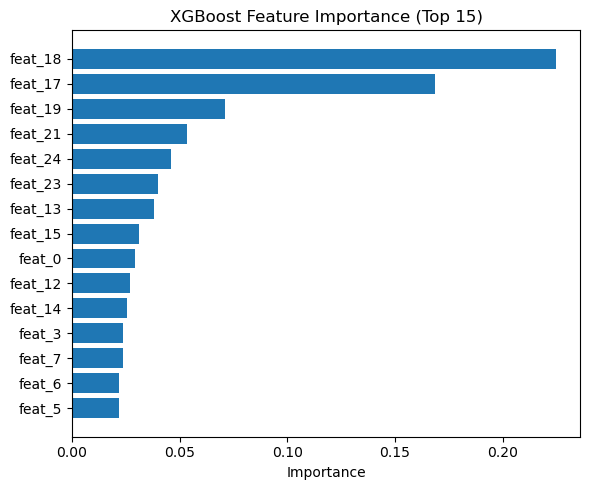

In [ ]:
feat_names = [f"feat_{i}" for i in range(X_test_k.shape[1])]
imp = pd.Series(best_xgb.feature_importances_, index=feat_names).sort_values(ascending=False)

top = imp.head(15).iloc[::-1]
plt.figure(figsize=(6,5))
plt.barh(top.index, top.values)
plt.xlabel("Importance")
plt.title("XGBoost Feature Importance (Top 15)")
plt.tight_layout()
plt.show()

# feat_names = [
#     "eig_1", "eig_2", "eig_3", "eig_4", "eig_5", "eig_6", "eig_7", "eig_8", "eig_9",
#     "charge", "spin", "reaction size"
# ]

# # Create importance Series
# imp = pd.Series(best_xgb.feature_importances_, index=feat_names).sort_values(ascending=False)

# # Plot top 15
# top = imp.head(15).iloc[::-1]
# plt.figure(figsize=(6,5))
# plt.barh(top.index, top.values)
# plt.xlabel("Importance")
# plt.title("XGBoost Feature Importance (Top 15)")
# plt.tight_layout()
# plt.show()

/opt/anaconda3/lib/python3.12/site-packages/shap/explainers/_tree.py:253: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(


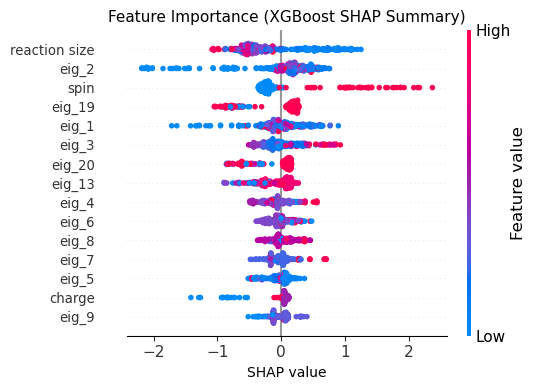

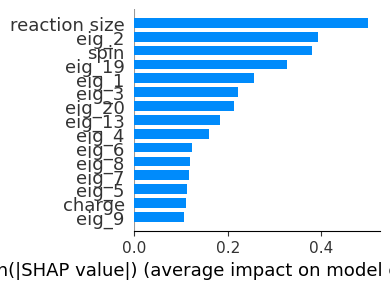

In [26]:
import shap

# feat_names = [f"feat_{i}" for i in range(X_test_k.shape[1])]
# Xtr_df = pd.DataFrame(X_trainval_k, columns=feat_names)
# Xte_df = pd.DataFrame(X_test_k,     columns=feat_names)

# explainer = shap.TreeExplainer(best_xgb, feature_perturbation="interventional")
# shap_vals = explainer.shap_values(Xte_df)

# # 1) Beeswarm summary
# plt.figure(figsize=(5.5,4))
# shap.summary_plot(
#     shap_vals, Xte_df,
#     show=False,
#     max_display=15,
#     plot_size=(5.5,4),
# )
# plt.tight_layout()
# plt.show()

# # 2) Bar summary
# plt.figure(figsize=(4,3))
# shap.summary_plot(
#     shap_vals, Xte_df,
#     plot_type="bar",
#     show=False,
#     max_display=15,
#     plot_size=(4,3),
# )
# plt.tight_layout()
# plt.show()

feat_names = [
    "eig_1", "eig_2", "eig_3", "eig_4", "eig_5", "eig_6", "eig_7", "eig_8", "eig_9",
    "eig_10", "eig_11", "eig_12", "eig_13", "eig_14", "eig_15", "eig_16", "eig_17",
    "eig_18", "eig_19", "eig_20", "eig_21", "eig_22",
    "charge", "spin", "reaction size"
]


# DataFrames with renamed columns
Xtr_df = pd.DataFrame(X_trainval_k, columns=feat_names)
Xte_df = pd.DataFrame(X_test_k,     columns=feat_names)

# SHAP explanation
explainer = shap.TreeExplainer(best_xgb, feature_perturbation="interventional")
shap_vals = explainer.shap_values(Xte_df)

plt.figure(figsize=(5.5,4))
shap.summary_plot(
    shap_vals, Xte_df,
    show=False,
    max_display=15,
    plot_size=(5.5,4),
)

plt.title("Feature Importance (XGBoost SHAP Summary)", fontsize=11)
plt.xlabel("SHAP value", fontsize=10)


plt.yticks(fontsize=9.5) 
plt.tight_layout()
plt.show()

#  Bar summary
plt.figure(figsize=(4,3))
shap.summary_plot(
    shap_vals, Xte_df,
    plot_type="bar",
    show=False,
    max_display=15,
    plot_size=(4,3),
)
plt.tight_layout()
plt.show()


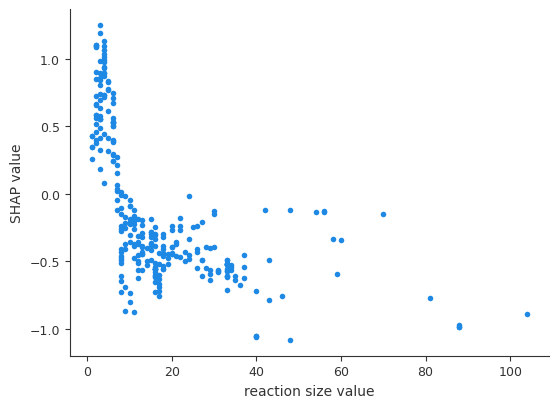

Top SHAP feature: reaction size


In [ ]:
#  Single-feature SHAP dependence 
mean_abs = np.abs(shap_vals).mean(axis=0)
top_idx  = int(mean_abs.argmax())
top_feat = Xte_df.columns[top_idx]

# Create larger figure and use explicit axis
fig, ax = plt.subplots(figsize=(5.5, 4))  
shap.dependence_plot(
    top_feat,
    shap_vals,
    Xte_df,
    interaction_index=None,
    ax=ax,
    show=False
)

plt.xlabel(f"{top_feat} value", fontsize=10)
plt.ylabel("SHAP value", fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout(pad=0.4)
plt.show()
print(f"Top SHAP feature: {top_feat}")


# Decision tree classifier

In [50]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

results_dt = []        # list of dicts per K (DT)
search_by_K_dt = {}    # keep fitted search per K

# DT search space (kept compact for speed)
param_dist_dt = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [None, 4, 6, 8, 10, 12],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 3, 5],
    "max_features": [None, "sqrt", 0.5],
    "class_weight": ["balanced"],  # imbalance handling analogous to XGB spw
}

for K in K_list:
    # print(K)
    Xi = np.hstack([X_trainval[:, :K], X_trainval[:, -3:]])  # top-K eigvals + 3 metadata

    dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
    search_dt = RandomizedSearchCV(
        estimator=dt,
        param_distributions=param_dist_dt,
        n_iter=30,                     # reduce if needed; raise to 50 for parity
        scoring=scoring,               # {"bal_acc": "balanced_accuracy", "acc": "accuracy"}
        refit="bal_acc",
        cv=inner_cv,                   # StratifiedKFold(5, shuffle=True, random_state=...)
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=0,
    )

    search_dt.fit(Xi, y_trainval)

    best_idx = search_dt.best_index_
    splits = inner_cv.get_n_splits()
    bal_folds = [search_dt.cv_results_[f"split{i}_test_bal_acc"][best_idx] for i in range(splits)]
    acc_folds = [search_dt.cv_results_[f"split{i}_test_acc"][best_idx]     for i in range(splits)]

    rec = {
        "K": K,
        "bal_mean": float(search_dt.cv_results_["mean_test_bal_acc"][best_idx]),
        "bal_std":  float(np.std(bal_folds)),
        "acc_mean": float(search_dt.cv_results_["mean_test_acc"][best_idx]),
        "acc_std":  float(np.std(acc_folds)),
        "best_params": search_dt.best_params_,
    }
    results_dt.append(rec)
    search_by_K_dt[K] = search_dt


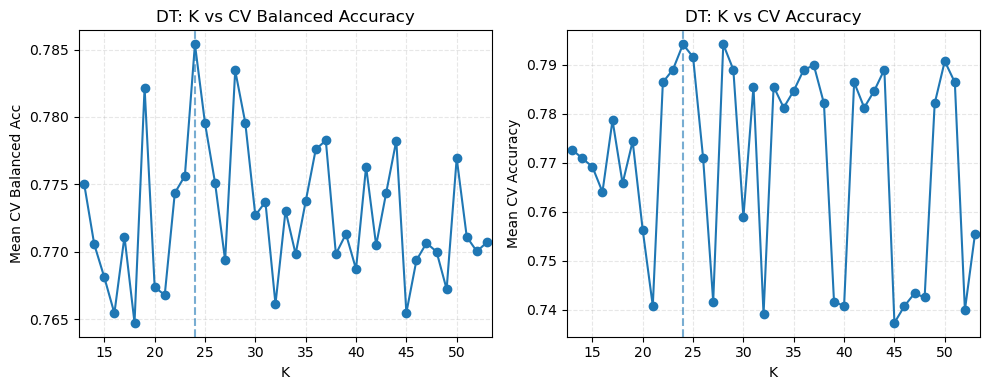

In [51]:
df_dt = pd.DataFrame(results_dt).sort_values("K").reset_index(drop=True)

# Best K by balanced accuracy (tie-break: acc_mean, then smaller K)
best_rec_dt = max(df_dt.to_dict("records"), key=lambda d: (d["bal_mean"], d["acc_mean"], -d["K"]))
K_star_dt = best_rec_dt["K"]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

# Left: balanced accuracy vs K
axes[0].plot(df_dt["K"], df_dt["bal_mean"], "o-")
axes[0].axvline(K_star_dt, linestyle="--", alpha=0.6)
axes[0].set_title("DT: K vs CV Balanced Accuracy")
axes[0].set_xlabel("K")
axes[0].set_ylabel("Mean CV Balanced Acc")
axes[0].grid(alpha=0.3, linestyle="--")

# Right: accuracy vs K
axes[1].plot(df_dt["K"], df_dt["acc_mean"], "o-")
axes[1].axvline(K_star_dt, linestyle="--", alpha=0.6)
axes[1].set_title("DT: K vs CV Accuracy")
axes[1].set_xlabel("K")
axes[1].set_ylabel("Mean CV Accuracy")
axes[1].grid(alpha=0.3, linestyle="--")

axes[1].set_xlim(df_dt["K"].min() - 0.5, df_dt["K"].max() + 0.5)

plt.tight_layout()
plt.show()


In [ ]:
# Summary sorted by balanced accuracy
results_dt.sort(key=lambda d: d["bal_mean"], reverse=True)

print("\n=== Decision Tree RandomizedSearch (5-fold), per-K summary — sorted by balanced accuracy ===")
print(" K   bal_mean  bal_sd   acc_mean  acc_sd ")
for r in results_dt:
    print(f"{r['K']:2d}   {r['bal_mean']:.3f}    {r['bal_std']:.3f}    "
          f"{r['acc_mean']:.3f}    {r['acc_std']:.3f}")

# Best K
best_dt = max(results_dt, key=lambda d: (d["bal_mean"], d["acc_mean"], -d["K"]))
K_star_dt = best_dt["K"]

print(f"\n>>> Selected K*_DT = {K_star_dt} by BEST bal_acc "
      f"(best bal_acc={best_dt['bal_mean']:.3f}±{best_dt['bal_std']:.3f}; "
      f"acc_mean={best_dt['acc_mean']:.3f}±{best_dt['acc_std']:.3f})")
print("Winner params (DT):", best_dt.get("best_params"))


=== Decision Tree RandomizedSearch (5-fold), per-K summary — sorted by balanced accuracy ===
 K   bal_mean  bal_sd   acc_mean  acc_sd 
24   0.785    0.011    0.794    0.005
28   0.783    0.013    0.794    0.011
19   0.782    0.013    0.774    0.020
29   0.780    0.012    0.789    0.006
25   0.780    0.010    0.792    0.010
37   0.778    0.011    0.790    0.006
44   0.778    0.010    0.789    0.010
36   0.778    0.011    0.789    0.008
50   0.777    0.018    0.791    0.016
41   0.776    0.010    0.786    0.010
23   0.776    0.010    0.789    0.007
26   0.775    0.021    0.771    0.017
43   0.774    0.012    0.785    0.009
22   0.774    0.006    0.786    0.005
35   0.774    0.016    0.785    0.008
31   0.774    0.005    0.786    0.009
33   0.773    0.006    0.786    0.004
30   0.773    0.021    0.759    0.022
39   0.771    0.013    0.742    0.023
17   0.771    0.015    0.779    0.011
51   0.771    0.018    0.786    0.014
53   0.771    0.016    0.755    0.012
47   0.771    0.013    0.743

In [32]:
# ===== Decision Tree: refit on all train/val with K*_DT and evaluate on test =====
print(K_star_dt)

# Build K*-DT feature matrices (top-K eigenvalues + 3 metadata)
X_trainval_k_dt = np.hstack([X_trainval[:, :K_star_dt], X_trainval[:, -3:]])
X_test_k_dt     = np.hstack([X_test[:, :K_star_dt],     X_test[:, -3:]])

# Best DT from search (already refit inside CV on folds); refit on full train/val
best_dt = search_by_K_dt[K_star_dt].best_estimator_
best_dt.fit(X_trainval_k_dt, y_trainval)

# Train eval
y_pred_tr_dt = best_dt.predict(X_trainval_k_dt)
y_prob_tr_dt = best_dt.predict_proba(X_trainval_k_dt)[:, 1]
print("\n=== Decision Tree — Train Set Performance ===")
print(classification_report(y_trainval, y_pred_tr_dt, digits=2))
print("Train Accuracy:", accuracy_score(y_trainval, y_pred_tr_dt))
print("Train Balanced Acc:", balanced_accuracy_score(y_trainval, y_pred_tr_dt))
print("Train ROC-AUC:", roc_auc_score(y_trainval, y_prob_tr_dt))
print("Train PR-AUC:", average_precision_score(y_trainval, y_prob_tr_dt))

# Test eval
y_pred_te_dt = best_dt.predict(X_test_k_dt)
y_prob_te_dt = best_dt.predict_proba(X_test_k_dt)[:, 1]
print("\n=== Decision Tree — Test Set Performance ===")
print(classification_report(y_test, y_pred_te_dt, digits=2))
print("Test Accuracy:", accuracy_score(y_test, y_pred_te_dt))
print("Test Balanced Acc:", balanced_accuracy_score(y_test, y_pred_te_dt))
print("Test ROC-AUC:", roc_auc_score(y_test, y_prob_te_dt))
print("Test PR-AUC:", average_precision_score(y_test, y_prob_te_dt))


24

=== Decision Tree — Train Set Performance ===
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       775
           1       0.92      0.99      0.95       386

    accuracy                           0.97      1161
   macro avg       0.96      0.97      0.96      1161
weighted avg       0.97      0.97      0.97      1161

Train Accuracy: 0.9664082687338501
Train Balanced Acc: 0.9722380076884506
Train ROC-AUC: 0.9975681096439912
Train PR-AUC: 0.993017321336414

=== Decision Tree — Test Set Performance ===
              precision    recall  f1-score   support

           0       0.89      0.81      0.85       194
           1       0.68      0.80      0.74        97

    accuracy                           0.81       291
   macro avg       0.79      0.81      0.79       291
weighted avg       0.82      0.81      0.81       291

Test Accuracy: 0.8075601374570447
Test Balanced Acc: 0.8067010309278351
Test ROC-AUC: 0.8250876820065894
Test 

# Random Forest Classifier

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

results_rf = []        # per-K records
search_by_K_rf = {}    # fitted searches per K

# Compact RF search space (kept small for runtime)
param_dist_rf = {
    "n_estimators": [200,  300, 400],      # smaller forests for tuning; refit can use the best value
    "max_depth": [None, 6, 10],           # shallow or unbounded
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 3],
    "max_features": ["sqrt", 0.5],        # feature subsampling
    "bootstrap": [True],
    "class_weight": ["balanced"],         # imbalance handling analogous to XGB scale_pos_weight
}

K_list = [k for k in range(0, 54)]
K_list = [k for k in range(13, 54)]

for K in K_list:
    # print(K)
    Xi = np.hstack([X_trainval[:, :K], X_trainval[:, -3:]])  # top-K eigvals + 3 metadata

    rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
    search_rf = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist_rf,
        n_iter=24,                    # reduced search size to save time
        scoring=scoring,              # {"bal_acc": "balanced_accuracy", "acc": "accuracy"}
        refit="bal_acc",
        cv=inner_cv,                  # StratifiedKFold(5, shuffle=True, random_state=...)
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=0,
    )

    search_rf.fit(Xi, y_trainval)

    best_idx = search_rf.best_index_
    splits = inner_cv.get_n_splits()
    bal_folds = [search_rf.cv_results_[f"split{i}_test_bal_acc"][best_idx] for i in range(splits)]
    acc_folds = [search_rf.cv_results_[f"split{i}_test_acc"][best_idx]     for i in range(splits)]

    rec = {
        "K": K,
        "bal_mean": float(search_rf.cv_results_["mean_test_bal_acc"][best_idx]),
        "bal_std":  float(np.std(bal_folds)),
        "acc_mean": float(search_rf.cv_results_["mean_test_acc"][best_idx]),
        "acc_std":  float(np.std(acc_folds)),
        "best_params": search_rf.best_params_,
    }
    results_rf.append(rec)
    search_by_K_rf[K] = search_rf

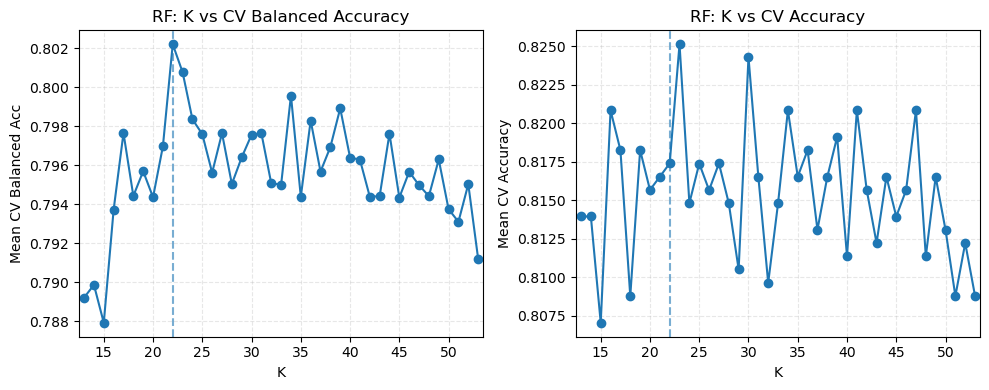

In [35]:
df_rf = pd.DataFrame(results_rf).sort_values("K").reset_index(drop=True)

# Best K by balanced accuracy (tie-break: acc_mean, then smaller K)
best_rec_rf = max(df_rf.to_dict("records"), key=lambda d: (d["bal_mean"], d["acc_mean"], -d["K"]))
K_star_rf = best_rec_rf["K"]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

# Left: balanced accuracy vs K
axes[0].plot(df_rf["K"], df_rf["bal_mean"], "o-")
axes[0].axvline(K_star_rf, linestyle="--", alpha=0.6)
axes[0].set_title("RF: K vs CV Balanced Accuracy")
axes[0].set_xlabel("K")
axes[0].set_ylabel("Mean CV Balanced Acc")
axes[0].grid(alpha=0.3, linestyle="--")

# Right: accuracy vs K
axes[1].plot(df_rf["K"], df_rf["acc_mean"], "o-")
axes[1].axvline(K_star_rf, linestyle="--", alpha=0.6)
axes[1].set_title("RF: K vs CV Accuracy")
axes[1].set_xlabel("K")
axes[1].set_ylabel("Mean CV Accuracy")
axes[1].grid(alpha=0.3, linestyle="--")

axes[1].set_xlim(df_rf["K"].min() - 0.5, df_rf["K"].max() + 0.5)

plt.tight_layout()
plt.show()

In [36]:
# Summary sorted by balanced accuracy
results_rf.sort(key=lambda d: d["bal_mean"], reverse=True)

print("\n=== Random Forest RandomizedSearch (5-fold), per-K summary — sorted by balanced accuracy ===")
print(" K   bal_mean  bal_sd   acc_mean  acc_sd ")
for r in results_rf:
    print(f"{r['K']:2d}   {r['bal_mean']:.3f}    {r['bal_std']:.3f}    "
          f"{r['acc_mean']:.3f}    {r['acc_std']:.3f}")

# Best K
best_rf_rec = max(results_rf, key=lambda d: (d["bal_mean"], d["acc_mean"], -d["K"]))
K_star_rf = best_rf_rec["K"]

print(f"\n>>> Selected K*_RF = {K_star_rf} by BEST bal_acc "
      f"(best bal_acc={best_rf_rec['bal_mean']:.3f}±{best_rf_rec['bal_std']:.3f}; "
      f"acc_mean={best_rf_rec['acc_mean']:.3f}±{best_rf_rec['acc_std']:.3f})")
print("Winner params (RF):", best_rf_rec.get("best_params"))



=== Random Forest RandomizedSearch (5-fold), per-K summary — sorted by balanced accuracy ===
 K   bal_mean  bal_sd   acc_mean  acc_sd 
22   0.802    0.020    0.817    0.015
23   0.801    0.012    0.825    0.012
34   0.800    0.014    0.821    0.010
39   0.799    0.020    0.819    0.015
24   0.798    0.025    0.815    0.016
36   0.798    0.019    0.818    0.011
17   0.798    0.017    0.818    0.010
27   0.798    0.018    0.817    0.012
31   0.798    0.016    0.817    0.012
44   0.798    0.012    0.817    0.007
25   0.798    0.013    0.817    0.013
30   0.798    0.017    0.824    0.014
21   0.797    0.013    0.817    0.006
38   0.797    0.021    0.817    0.019
29   0.796    0.025    0.811    0.018
40   0.796    0.019    0.811    0.013
49   0.796    0.019    0.817    0.016
41   0.796    0.014    0.821    0.010
19   0.796    0.017    0.818    0.011
37   0.796    0.014    0.813    0.012
46   0.796    0.008    0.816    0.007
26   0.796    0.010    0.816    0.011
32   0.795    0.017    0.810

In [37]:
print(K_star_rf)

# Build K*-RF feature matrices
X_trainval_k_rf = np.hstack([X_trainval[:, :K_star_rf], X_trainval[:, -3:]])
X_test_k_rf     = np.hstack([X_test[:, :K_star_rf],     X_test[:, -3:]])

# Best RF from search; refit on full train/val
best_rf = search_by_K_rf[K_star_rf].best_estimator_
best_rf.fit(X_trainval_k_rf, y_trainval)

# Train eval
y_pred_tr_rf = best_rf.predict(X_trainval_k_rf)
y_prob_tr_rf = best_rf.predict_proba(X_trainval_k_rf)[:, 1]
print("\n=== Random Forest — Train Set Performance ===")
print(classification_report(y_trainval, y_pred_tr_rf, digits=2))
print("Train Accuracy:", accuracy_score(y_trainval, y_pred_tr_rf))
print("Train Balanced Acc:", balanced_accuracy_score(y_trainval, y_pred_tr_rf))
print("Train ROC-AUC:", roc_auc_score(y_trainval, y_prob_tr_rf))
print("Train PR-AUC:", average_precision_score(y_trainval, y_prob_tr_rf))

# Test eval
y_pred_te_rf = best_rf.predict(X_test_k_rf)
y_prob_te_rf = best_rf.predict_proba(X_test_k_rf)[:, 1]
print("\n=== Random Forest — Test Set Performance ===")
print(classification_report(y_test, y_pred_te_rf, digits=2))
print("Test Accuracy:", accuracy_score(y_test, y_pred_te_rf))
print("Test Balanced Acc:", balanced_accuracy_score(y_test, y_pred_te_rf))
print("Test ROC-AUC:", roc_auc_score(y_test, y_prob_te_rf))
print("Test PR-AUC:", average_precision_score(y_test, y_prob_te_rf))


22

=== Random Forest — Train Set Performance ===
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       775
           1       0.86      1.00      0.93       386

    accuracy                           0.95      1161
   macro avg       0.93      0.96      0.94      1161
weighted avg       0.95      0.95      0.95      1161

Train Accuracy: 0.9474590869939707
Train Balanced Acc: 0.9606451612903226
Train ROC-AUC: 0.991592846398128
Train PR-AUC: 0.9811302617896961

=== Random Forest — Test Set Performance ===
              precision    recall  f1-score   support

           0       0.87      0.82      0.85       194
           1       0.68      0.76      0.72        97

    accuracy                           0.80       291
   macro avg       0.78      0.79      0.78       291
weighted avg       0.81      0.80      0.80       291

Test Accuracy: 0.8006872852233677
Test Balanced Acc: 0.7912371134020618
Test ROC-AUC: 0.8647305771070252
Test 

# Final result 

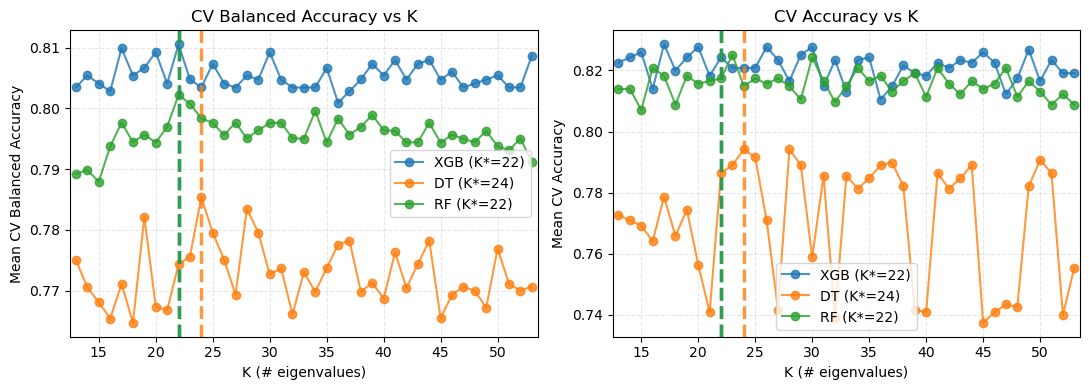

In [52]:
# ===== automatically pick best K* by highest Balanced Accuracy =====
K_star_xgb = df.loc[df["bal_mean"].idxmax(), "K"]
K_star_dt  = df_dt.loc[df_dt["bal_mean"].idxmax(), "K"]
K_star_rf  = df_rf.loc[df_rf["bal_mean"].idxmax(), "K"]

# ===== combined plot =====
fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharex=True)

colors = {"XGB": "C0", "DT": "C1", "RF": "C2"}

# ---- Balanced Accuracy ----
axes[0].plot(df["K"], df["bal_mean"], "o-", color=colors["XGB"], label=f"XGB (K*={K_star_xgb})", alpha=0.8)
axes[0].plot(df_dt["K"], df_dt["bal_mean"], "o-", color=colors["DT"], label=f"DT (K*={K_star_dt})", alpha=0.8)
axes[0].plot(df_rf["K"], df_rf["bal_mean"], "o-", color=colors["RF"], label=f"RF (K*={K_star_rf})", alpha=0.8)

axes[0].axvline(K_star_xgb, color=colors["XGB"], linewidth=2.5, linestyle="--", alpha=0.8)
axes[0].axvline(K_star_dt,  color=colors["DT"],  linewidth=2.5, linestyle="--", alpha=0.8)
axes[0].axvline(K_star_rf,  color=colors["RF"],  linewidth=2.5, linestyle="--", alpha=0.8)

axes[0].set_title("CV Balanced Accuracy vs K")
axes[0].set_xlabel("K (# eigenvalues)")
axes[0].set_ylabel("Mean CV Balanced Accuracy")
axes[0].grid(alpha=0.3, linestyle="--")
axes[0].legend()

# ---- Accuracy ----
axes[1].plot(df["K"], df["acc_mean"], "o-", color=colors["XGB"], label=f"XGB (K*={K_star_xgb})", alpha=0.8)
axes[1].plot(df_dt["K"], df_dt["acc_mean"], "o-", color=colors["DT"], label=f"DT (K*={K_star_dt})", alpha=0.8)
axes[1].plot(df_rf["K"], df_rf["acc_mean"], "o-", color=colors["RF"], label=f"RF (K*={K_star_rf})", alpha=0.8)

axes[1].axvline(K_star_xgb, color=colors["XGB"], linewidth=2.5, linestyle="--", alpha=0.8)
axes[1].axvline(K_star_dt,  color=colors["DT"],  linewidth=2.5, linestyle="--", alpha=0.8)
axes[1].axvline(K_star_rf,  color=colors["RF"],  linewidth=2.5, linestyle="--", alpha=0.8)

axes[1].set_title("CV Accuracy vs K")
axes[1].set_xlabel("K (# eigenvalues)")
axes[1].set_ylabel("Mean CV Accuracy")
axes[1].grid(alpha=0.3, linestyle="--")
axes[1].legend()

axes[1].set_xlim(
    min(df["K"].min(), df_dt["K"].min(), df_rf["K"].min()) - 0.5,
    max(df["K"].max(), df_dt["K"].max(), df_rf["K"].max()) + 0.5
)

plt.tight_layout()
plt.show()


In [53]:
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
    average_precision_score,
)
import numpy as np

# --- pick best Ks automatically (restricted region K ≥ 15) ---
df_sub     = df[df["K"] >= 15]
df_dt_sub  = df_dt[df_dt["K"] >= 15]
df_rf_sub  = df_rf[df_rf["K"] >= 15]

best_rec_xgb = max(df_sub.to_dict("records"),    key=lambda d: (d["bal_mean"], d["acc_mean"], -d["K"]))
best_rec_dt  = max(df_dt_sub.to_dict("records"), key=lambda d: (d["bal_mean"], d["acc_mean"], -d["K"]))
best_rec_rf  = max(df_rf_sub.to_dict("records"), key=lambda d: (d["bal_mean"], d["acc_mean"], -d["K"]))

K_star_xgb = int(best_rec_xgb["K"])
K_star_dt  = int(best_rec_dt["K"])
K_star_rf  = int(best_rec_rf["K"])

print("Best Ks (K ≥ 15):")
print(f"  XGB = {K_star_xgb}, DT = {K_star_dt}, RF = {K_star_rf}")

# helper for top-K + metadata
def build_features(X, K):
    return np.hstack([X[:, :K], X[:, -3:]])

# --- XGBoost ---
X_trainval_xgb = build_features(X_trainval, K_star_xgb)
X_test_xgb     = build_features(X_test,      K_star_xgb)
best_xgb = search_by_K[K_star_xgb].best_estimator_
best_xgb.fit(X_trainval_xgb, y_trainval)

y_pred_te_xgb = best_xgb.predict(X_test_xgb)
y_prob_te_xgb = best_xgb.predict_proba(X_test_xgb)[:, 1]

print("\n=== XGBoost — Test Set Performance ===")
print(classification_report(y_test, y_pred_te_xgb, digits=3))
print("Test Accuracy:",      accuracy_score(y_test, y_pred_te_xgb))
print("Test Balanced Acc:",  balanced_accuracy_score(y_test, y_pred_te_xgb))
print("Test ROC-AUC:",       roc_auc_score(y_test, y_prob_te_xgb))
print("Test PR-AUC:",        average_precision_score(y_test, y_prob_te_xgb))

# --- Random Forest ---
X_trainval_rf = build_features(X_trainval, K_star_rf)
X_test_rf     = build_features(X_test,      K_star_rf)
best_rf = search_by_K_rf[K_star_rf].best_estimator_
best_rf.fit(X_trainval_rf, y_trainval)

y_pred_te_rf = best_rf.predict(X_test_rf)
y_prob_te_rf = best_rf.predict_proba(X_test_rf)[:, 1]

print("\n=== Random Forest — Test Set Performance ===")
print(classification_report(y_test, y_pred_te_rf, digits=3))
print("Test Accuracy:",      accuracy_score(y_test, y_pred_te_rf))
print("Test Balanced Acc:",  balanced_accuracy_score(y_test, y_pred_te_rf))
print("Test ROC-AUC:",       roc_auc_score(y_test, y_prob_te_rf))
print("Test PR-AUC:",        average_precision_score(y_test, y_prob_te_rf))


# --- Decision Tree ---
X_trainval_dt = build_features(X_trainval, K_star_dt)
X_test_dt     = build_features(X_test,      K_star_dt)
best_dt = search_by_K_dt[K_star_dt].best_estimator_
best_dt.fit(X_trainval_dt, y_trainval)

y_pred_te_dt = best_dt.predict(X_test_dt)
y_prob_te_dt = best_dt.predict_proba(X_test_dt)[:, 1]

print("\n=== Decision Tree — Test Set Performance ===")
print(classification_report(y_test, y_pred_te_dt, digits=3))
print("Test Accuracy:",      accuracy_score(y_test, y_pred_te_dt))
print("Test Balanced Acc:",  balanced_accuracy_score(y_test, y_pred_te_dt))
print("Test ROC-AUC:",       roc_auc_score(y_test, y_prob_te_dt))
print("Test PR-AUC:",        average_precision_score(y_test, y_prob_te_dt))


Best Ks (K ≥ 15):
  XGB = 22, DT = 24, RF = 22

=== XGBoost — Test Set Performance ===
              precision    recall  f1-score   support

           0      0.886     0.840     0.862       194
           1      0.710     0.784     0.745        97

    accuracy                          0.821       291
   macro avg      0.798     0.812     0.804       291
weighted avg      0.827     0.821     0.823       291

Test Accuracy: 0.8213058419243986
Test Balanced Acc: 0.8118556701030928
Test ROC-AUC: 0.8830640875757254
Test PR-AUC: 0.8127454724777682

=== Random Forest — Test Set Performance ===
              precision    recall  f1-score   support

           0      0.874     0.820     0.846       194
           1      0.679     0.763     0.718        97

    accuracy                          0.801       291
   macro avg      0.776     0.791     0.782       291
weighted avg      0.809     0.801     0.803       291

Test Accuracy: 0.8006872852233677
Test Balanced Acc: 0.7912371134020618
Test